In [651]:
import pandas as pd
import pymc3 as pm
import numpy as np
import glob
import os
import pickle as pkl
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [652]:
# code for smooth switch point:
# https://gist.github.com/junpenglao/f7098c8e0d6eadc61b3e1bc8525dd90d
import theano.tensor as tt
from pymc3.distributions.transforms import ElemwiseTransform, Transform

class Ordered(ElemwiseTransform):
    name = "ordered"

    def backward(self, y):
        out = tt.zeros(y.shape)
        out = tt.inc_subtensor(out[0], y[0])
        out = tt.inc_subtensor(out[1:], tt.exp(y[1:]))
        return tt.cumsum(out)

    def forward(self, x):
        out = tt.zeros(x.shape)
        out = tt.inc_subtensor(out[0], x[0])
        out = tt.inc_subtensor(out[1:], tt.log(x[1:] - x[:-1]))
        return out

    def forward_val(self, x, point=None):
        x, = draw_values([x], point=point)
        return self.forward(x)

    def jacobian_det(self, y):
        return tt.sum(y[1:])

ordered = Ordered()


class Composed(Transform):
    def __init__(self, transform1, transform2):
        self._transform1 = transform1
        self._transform2 = transform2
        self.name = '_'.join([transform1.name, transform2.name])

    def forward(self, x):
        return self._transform2.forward(self._transform1.forward(x))

    def forward_val(self, x, point=None):
        return self.forward(x)

    def backward(self, y):
        return self._transform1.backward(self._transform2.backward(y))

    def jacobian_det(self, y):
        y2 = self._transform2.backward(y)
        det1 = self._transform1.jacobian_det(y2)
        det2 = self._transform2.jacobian_det(y)
        return det1 + det2
    
def logistic(L, x0, k=50, t_=np.linspace(0., 1., 1000)):
    x0 = x0*(t_.max()-t_.min()) + t_.min()  # scale x0 to t_
    return L/(1+tt.exp(-k*(t_-x0)))

In [653]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('colormap', ['blue', 'lightgray', 'red'])
def plot_ellipse_values(values, ellipse_pars=None, size=(1000, 1000), vmin=None, vmax=None, cmap=plt.cm.coolwarm, ax=None, **kwargs):

    ''' values is a n-by-m array'''

    values[np.isnan(values)] = 0
    if ellipse_pars is None:
        a = 350
        b = 150
        x = 500
        y = 500

        theta = 45. / 180 * np.pi

    else:
        a, b, x, y, theta = ellipse_pars

    A = a**2 * (np.sin(theta))**2 + b**2 * (np.cos(theta))**2
    B = 2 * (b**2 - a**2) * np.sin(theta) * np.cos(theta)
    C = a**2 * np.cos(theta)**2 + b**2 * np.sin(theta)**2
    D = -2 * A * x - B* y
    E = -B * x - 2 * C * y
    F = A* x**2 + B*x*y + C*y**2 - a**2*b**2

    X,Y = np.meshgrid(np.arange(size[0]), np.arange(size[1]))

    in_ellipse = A*X**2 + B*X*Y +C*Y**2 + D*X + E*Y +F < 0

    pc1 = np.array([[np.cos(theta)], [np.sin(theta)]])
    pc2 = np.array([[np.cos(theta - np.pi/2.)], [np.sin(theta - np.pi/2.)]])

    pc1_distance = pc1.T.dot(np.array([(X - x).ravel(), (Y - y).ravel()])).reshape(X.shape)
    pc2_distance = pc2.T.dot(np.array([(X - x).ravel(), (Y - y).ravel()])).reshape(X.shape)

    pc1_quantile = np.floor((pc1_distance / a + 1 ) / 2. * values.shape[0])
    pc2_quantile = np.floor((pc2_distance / b + 1 ) / 2. * values.shape[1])

    im = np.zeros_like(X, dtype=float)

    for pc1_q in np.arange(values.shape[0]):
        for pc2_q in np.arange(values.shape[1]):
            im[in_ellipse * (pc1_quantile == pc1_q) & (pc2_quantile == pc2_q)] = values[pc1_q, pc2_q]

    im = np.ma.masked_array(im, ~in_ellipse)
#     cmap.set_bad('grey')
    if ax is None:
        cax = plt.imshow(im, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax, **kwargs)
    else:
        ax.imshow(im, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax, **kwargs)
        cax = ax
#    sns.despine()

    return cax

def visualize_stn_model(df, dependent_var='y', ax=None, vmin=None, vmax=None, **kwargs):
    if ax is None:
        f, ax = plt.subplots(1, 1)
    # recode... ugly
    df['pc1_sector_name'] = 'vmd_' + df['pc1_sector_number'].astype(int).astype(str)
    df['pc2_sector_name'] = 'mml_' + df['pc2_sector_number'].astype(int).astype(str)
    vmd_labels = df['pc1_sector_name'].unique()
    mml_labels = df['pc2_sector_name'].unique()
    
    unstacked = df.groupby(['pc1_sector_name', 'pc2_sector_name'])[dependent_var].mean().unstack(1).ix[vmd_labels, mml_labels]

    if vmin is None:
        vmin = np.nanpercentile(unstacked.values, 5)
    if vmax is None:
        vmax = np.nanpercentile(unstacked.values, 95)
    plot_ellipse_values(unstacked.values, ax=ax, vmin=vmin, vmax=vmax, **kwargs)
    ax.axis('off')
    return ax

def plot_intensity_across_axis(df, dependent_var='y', x_axis='pc1_mm', ax=None, **kwargs):
    if ax is None:
        f, ax = plt.subplots(1, 1)
        
    data_per_coordinate = df.groupby([x_axis])[dependent_var].mean().reset_index()
    ax.plot(data_per_coordinate[x_axis], data_per_coordinate[dependent_var], **kwargs)
    ax.set_xlabel(x_axis)
    ax.set_ylabel('Rate')
    return ax

In [654]:
def np_logistic(L, x0, k=50, t_=np.linspace(0., 1., 1000)):
    x0 = x0*(t_.max()-t_.min()) + t_.min()  # scale x0 to t_
    return L/(1+np.exp(-k*(t_-x0)))

def ppc_stn(df, trace, model_n=1, n_samples=500):
    
    trace_df = pm.trace_to_dataframe(trace)
    out_array = np.empty((df.shape[0], n_samples))

    for i in np.arange(n_samples):
        if i % 10 == 0:
            print('.', end='')
        random_row = np.random.randint(low=0, high=trace_df.shape[0])
        
        if model_n == 1:
            ev = np.exp(trace_df.iloc[random_row]['intercept'])
        elif model_n == 2:
            ev = np.exp(trace_df.iloc[random_row]['intercept'] + \
                        trace_df.iloc[random_row]['beta_pca_1']*df['pc1_mm_norm'].values)
        elif model_n == 3:
            intercept = trace_df.iloc[random_row]['intercept']
            delta_center_1 = trace_df.iloc[random_row]['delta_center_1']
            delta_center_3 = trace_df.iloc[random_row]['delta_center_3']

            ev = np.exp(intercept + \
                        delta_center_1*((df['pc1_mm_perc'].values<0.333).astype(int)) + \
                        delta_center_3*((df['pc1_mm_perc'].values>0.667).astype(int)))

        elif model_n == 4:
            ev = np.exp(trace_df.iloc[random_row]['intercept'] + \
                        trace_df.iloc[random_row]['beta_pca_1']*df['pc1_mm_norm'].values + \
                        trace_df.iloc[random_row]['beta_pca_2']*df['pc2_mm_norm'].values + \
                        trace_df.iloc[random_row]['beta_slice']*df['slice_mm_norm'].values)
            
#         elif model_n == 5:
#             this_int = trace_df.iloc[random_row]['intercept']
#             this_lambda_0 = trace_df.iloc[random_row]['lambdad__0']
#             this_lambda_1 = trace_df.iloc[random_row]['lambdad__1']
#             this_b_0 = trace_df.iloc[random_row]['b__0']
#             this_b_1 = trace_df.iloc[random_row]['b__1']
#             ev = np.exp(this_int + \
#                         this_int*np_logistic(this_lambda_0, this_b_0, k=-50, t_=df['pc1_mm_perc'].values) +\
#                         this_int*np_logistic(this_lambda_1, this_b_1, k=50, t_=df['pc1_mm_perc'].values))
            
        elif model_n == 5:
            this_int = trace_df.iloc[random_row]['intercept']
            this_lambda_0 = trace_df.iloc[random_row]['lambdad__0']
            this_lambda_1 = trace_df.iloc[random_row]['lambdad__1']
            this_k = trace_df.iloc[random_row]['k']
            this_b_0 = trace_df.iloc[random_row]['b__0']
            this_b_1 = trace_df.iloc[random_row]['b__1']
            ev = np.exp(this_int + \
                        np_logistic(this_lambda_0, this_b_0, k=-this_k, t_=df['pc1_mm_norm'].values) +\
                        np_logistic(this_lambda_1, this_b_1, k=this_k, t_=df['pc1_mm_norm'].values))
                        
        elif model_n == 6:
            this_int = trace_df.iloc[random_row]['intercept']
            this_lambda_0 = trace_df.iloc[random_row]['lambdad__0']
            this_lambda_1 = trace_df.iloc[random_row]['lambdad__1']
            this_b_0 = trace_df.iloc[random_row]['b__0']
            this_b_1 = trace_df.iloc[random_row]['b__1']
            this_beta_1 = trace_df.iloc[random_row]['beta_pca_1']
            this_beta_2 = trace_df.iloc[random_row]['beta_pca_2']
            this_beta_slice = trace_df.iloc[random_row]['beta_slice']
            this_smoothness = trace_df.iloc[random_row]['smoothness']
            
            O_vec = this_beta_1*df['pc1_mm'].values + \
                    this_beta_2*df['pc2_mm'].values + \
                    this_beta_slice*df['slice_mm'].values
        
            # set O to scale 0-1, use this for cut-off
            O_vec = (O_vec-O_vec.mean())/(O_vec.std())

            ev = np.exp(this_int + \
                        np_logistic(this_lambda_0, this_b_0, k=this_smoothness, t_=O_vec) +\
                        np_logistic(this_lambda_1, this_b_1, k=this_smoothness, t_=O_vec))
        elif model_n == 7:
            this_int = trace_df.iloc[random_row]['intercept']
            this_lambda_0 = trace_df.iloc[random_row]['lambdad__0']
            this_lambda_1 = trace_df.iloc[random_row]['lambdad__1']
            this_b_0 = trace_df.iloc[random_row]['b__0']
            this_b_1 = trace_df.iloc[random_row]['b__1']
            this_beta_1 = trace_df.iloc[random_row]['beta_pca_1']
            this_beta_2 = trace_df.iloc[random_row]['beta_pca_2']
            this_beta_slice = trace_df.iloc[random_row]['beta_slice']
            this_smoothness = trace_df.iloc[random_row]['smoothness']
            
            O_vec = this_beta_1*df['pc2.1'].values + \
                    this_beta_2*df['pc2.2'].values + \
                    this_beta_slice*df['pc2.3'].values
        
            # set O to scale 0-1, use this for cut-off
            O_vec = (O_vec-O_vec.min())/(O_vec.max()-O_vec.min())

            ev = np.exp(this_int + \
                        this_int*np_logistic(this_lambda_0, this_b_0, k=this_smoothness, t_=O_vec) +\
                        this_int*np_logistic(this_lambda_1, this_b_1, k=this_smoothness, t_=O_vec))

        out_array[:,i] = ev
        
    return out_array

In [677]:
def load_model_traces(subject_id, stain, model_n, distribution, output_dir='./models_local11'):
    trace_fn = os.path.join(output_dir, 'sub-{}_stain-{}_model-{}_distribution-{}_type-traces.pkl').format(subject_id, stain, model_n, distribution)
    model_fn = os.path.join(output_dir, 'sub-{}_stain-{}_model-{}_distribution-{}_type-model.pkl').format(subject_id, stain, model_n, distribution)

    with open(model_fn, 'rb') as f:
        model = pkl.load(f)
    with open(trace_fn, 'rb') as f:
        traces = pkl.load(f)
    return model, traces

In [678]:
# load data
df = pd.read_pickle('./data_fwhm-0.3.pkl')

cols = ['pc1_mm_norm', 'pc2_mm_norm', 'slice_mm_norm']
from sklearn.decomposition import PCA
pca = PCA()


# Example that samples well

..................................................

mean        sd  mc_error   hpd_2.5  hpd_97.5        n_eff  \
intercept   0.560917  0.294711  0.019234  0.041393  1.133694    13.897233   
lambdad__0  0.336801  0.971875  0.030679 -1.650351  2.086669   110.334510   
lambdad__1  2.708414  0.648083  0.047651  1.478543  3.805538    10.334638   
beta_pca_1  1.604285  0.675294  0.012342  0.409773  2.920685  3412.519307   
beta_pca_2  0.005163  0.005840  0.000084  0.000002  0.017009  4733.398242   
beta_slice  0.016758  0.024373  0.001272  0.000003  0.063674    22.938135   
smoothness  0.644101  0.771347  0.074990  0.182176  2.358794     5.560379   
b__0        0.303870  0.149413  0.009077  0.064856  0.575805    15.137070   
b__1        0.675765  0.157412  0.010296  0.406644  0.938868    12.439531   

                 Rhat  
intercept    1.335306  
lambdad__0   1.047398  
lambdad__1   1.521165  
beta_pca_1   1.001853  
beta_pca_2   0.999702  
beta_slice   1.184738  
smoothness  10.463410  
b__0         1.281687  
b__1         1.360325

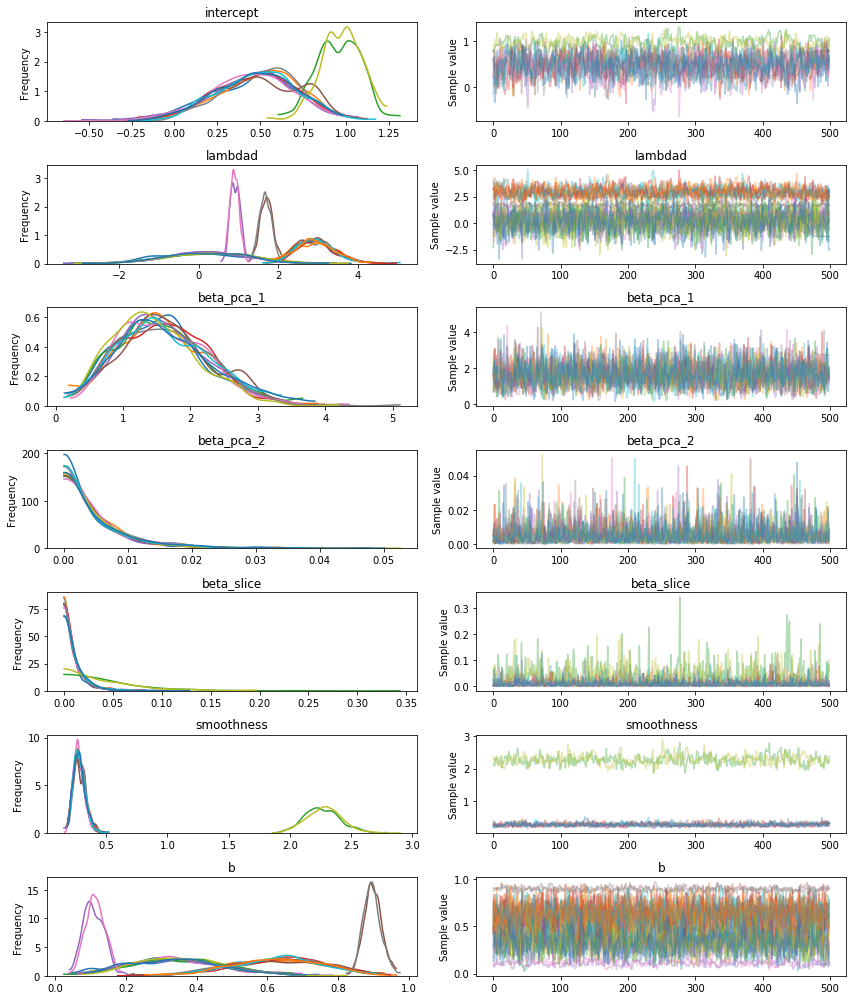

In [679]:
subj_id = 13095 #13095#14037
stain = 'FER'
model_n = 6
distribution = 'poisson'
model, traces = load_model_traces(subj_id, stain, model_n, distribution)
data_df_idx = (df.subject_id==subj_id) & (df.stain==stain)


#pca..
df_tmp = df.loc[data_df_idx,:].copy()
# pca.fit_transform(df_tmp[cols])
# df_tmp['pc2.1'] = pca.components_.dot(df_tmp[cols].values.T)[0,:]
# df_tmp['pc2.2'] = pca.components_.dot(df_tmp[cols].values.T)[1,:]
# df_tmp['pc2.3'] = pca.components_.dot(df_tmp[cols].values.T)[2,:]

ppc = ppc_stn(df=df_tmp, trace=traces, model_n=model_n, n_samples=500)
ppc_mean = ppc.mean(axis=1)
df_tmp['y_predicted'] = ppc_mean

pm.traceplot(traces)
display(pm.summary(traces))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:64: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


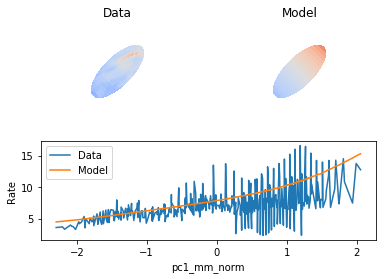

In [680]:
def plot_pc1(df):
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    gs = gridspec.GridSpec(2, 2)
    ax_stn_data = plt.subplot(gs[0,0])
    ax_stn_model = plt.subplot(gs[0,1])
    ax_graph = plt.subplot(gs[1,:])
    vmin = np.nanpercentile(df['rate'], 5)
    vmax = np.nanpercentile(df['rate'], 95)

    visualize_stn_model(df, dependent_var='rate', ax=ax_stn_data, vmin=vmin, vmax=vmax)
    visualize_stn_model(df, dependent_var='y_predicted', ax=ax_stn_model, vmin=vmin, vmax=vmax)
    plot_intensity_across_axis(df, dependent_var='rate', ax=ax_graph, x_axis='pc1_mm_norm', label='Data')
    plot_intensity_across_axis(df, dependent_var='y_predicted', ax=ax_graph, x_axis='pc1_mm_norm', label='Model')

    ax_stn_data.set_title('Data')
    ax_stn_model.set_title('Model')
    ax_graph.legend()
plot_pc1(df_tmp)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:64: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/opt/conda/lib/python3.6/site-package

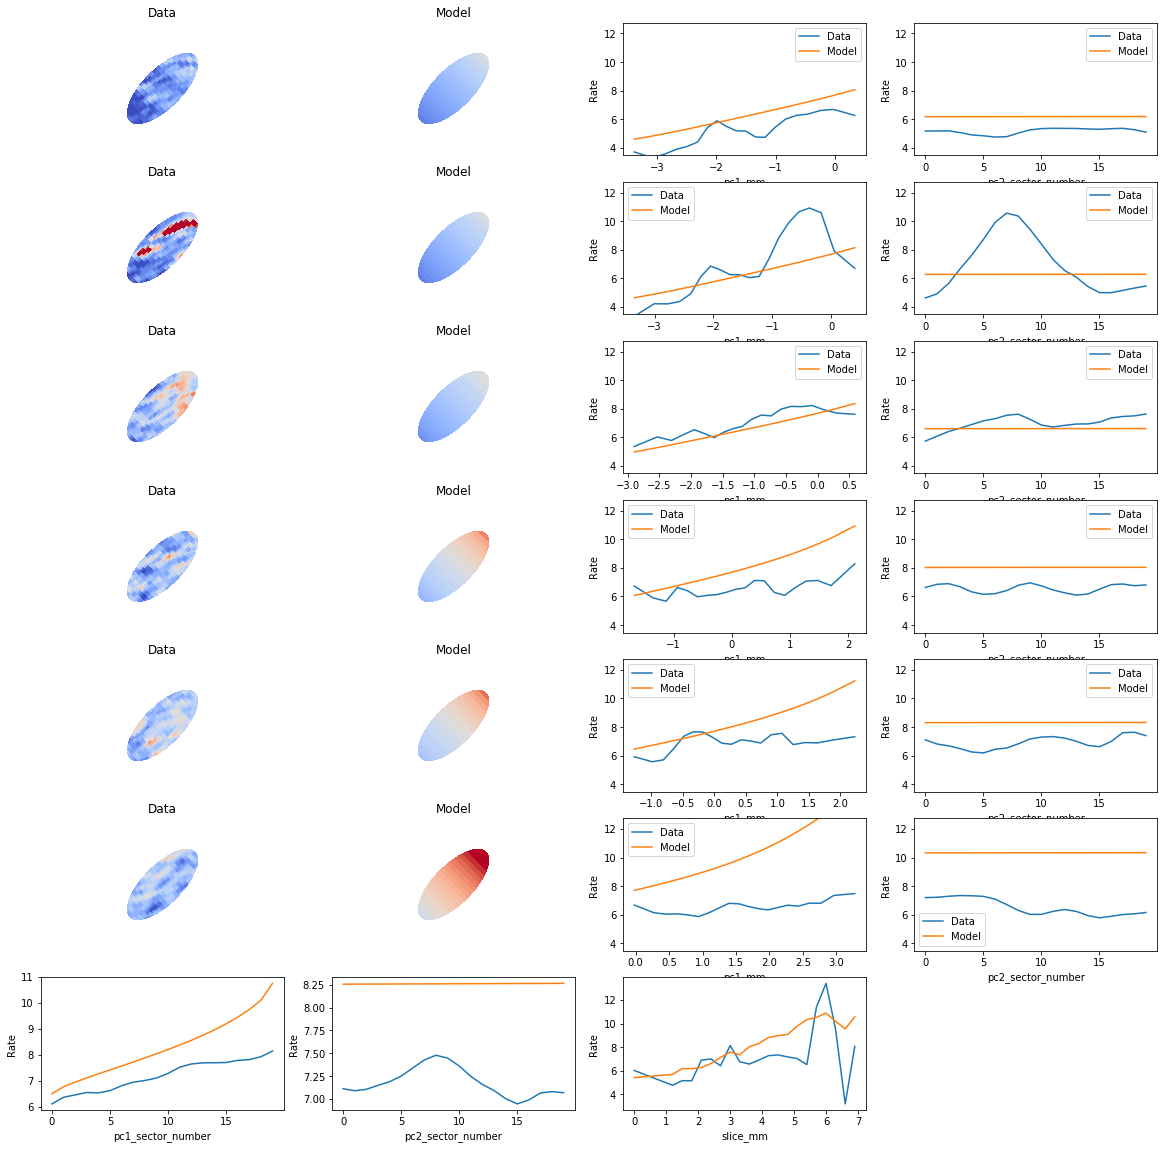

In [681]:
def plot_per_slice(df, slices=[1,2,5,8,10,15]):
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    gs = gridspec.GridSpec(len(slices)+1, 4)

    vmin = np.nanpercentile(df['rate'], 5)
    vmax = np.nanpercentile(df['rate'], 95)
    for row_n, slice_id in enumerate(slices):
        df_this_slice = df.loc[df.slice_sector==df.slice_sector.unique()[slice_id]]
        ax_stn_data = plt.subplot(gs[row_n,0])
        ax_stn_model = plt.subplot(gs[row_n,1])
        ax_graph_pc1 = plt.subplot(gs[row_n,2])
        ax_graph_pc2 = plt.subplot(gs[row_n,3])

        visualize_stn_model(df_this_slice, dependent_var='rate', ax=ax_stn_data, vmin=vmin, vmax=vmax)
        visualize_stn_model(df_this_slice, dependent_var='y_predicted', ax=ax_stn_model, vmin=vmin, vmax=vmax)
        plot_intensity_across_axis(df_this_slice, dependent_var='rate', ax=ax_graph_pc1, label='Data')
        plot_intensity_across_axis(df_this_slice, dependent_var='y_predicted', ax=ax_graph_pc1, label='Model')
        plot_intensity_across_axis(df_this_slice, x_axis='pc2_sector_number', dependent_var='rate', ax=ax_graph_pc2, label='Data')
        plot_intensity_across_axis(df_this_slice, x_axis='pc2_sector_number', dependent_var='y_predicted', ax=ax_graph_pc2, label='Model')

        ax_stn_data.set_title('Data')
        ax_stn_model.set_title('Model')
        ax_graph_pc1.legend()
        ax_graph_pc1.set_ylim(vmin, vmax)
        ax_graph_pc2.legend()
        ax_graph_pc2.set_ylim(vmin, vmax)

    # some overall plots (across pc1, pc2, slice)
    plot_intensity_across_axis(df, x_axis='pc1_sector_number', dependent_var='rate', ax=plt.subplot(gs[-1,0]), label='Data')
    plot_intensity_across_axis(df, x_axis='pc1_sector_number', dependent_var='y_predicted', ax=plt.subplot(gs[-1,0]), label='Model')
    plot_intensity_across_axis(df, x_axis='pc2_sector_number', dependent_var='rate', ax=plt.subplot(gs[-1,1]), label='Data')
    plot_intensity_across_axis(df, x_axis='pc2_sector_number', dependent_var='y_predicted', ax=plt.subplot(gs[-1,1]), label='Model')
    plot_intensity_across_axis(df, x_axis='slice_mm', dependent_var='rate', ax=plt.subplot(gs[-1,2]), label='Data')
    plot_intensity_across_axis(df, x_axis='slice_mm', dependent_var='y_predicted', ax=plt.subplot(gs[-1,2]), label='Model')

    plt.gcf().set_size_inches(20, 20)
    
plot_per_slice(df_tmp)

Visualize cut-off axis

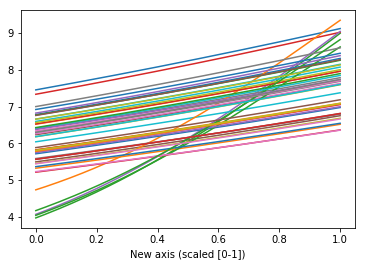

In [686]:
def plot_cutoff_axis(traces, this_df, n_samples=50, model=7):
    trace_df = pm.trace_to_dataframe(traces)

    for i in range(n_samples):
        random_row = np.random.randint(low=0, high=trace_df.shape[0])
        
        if model == 5:
            this_int = trace_df.iloc[random_row]['intercept']
            this_lambda_0 = trace_df.iloc[random_row]['lambdad__0']
            this_lambda_1 = trace_df.iloc[random_row]['lambdad__1']
            this_k = trace_df.iloc[random_row]['k']
#             this_smoothness = trace_df.iloc[random_row]['smoothness']
            this_b_0 = trace_df.iloc[random_row]['b__0']
            this_b_1 = trace_df.iloc[random_row]['b__1']
            
            x = df['pc1_mm_norm'].values
            x.sort()
            ev = np.exp(this_int + \
                        this_int*np_logistic(this_lambda_0, this_b_0, k=-this_k, t_=x) +\
                        this_int*np_logistic(this_lambda_1, this_b_1, k=this_k, t_=x))
            plt.plot(x, ev)
            plt.axhline(np.exp(this_int))
            plt.xlabel('PC1 (mm, normalized)')
        if model >= 6:
            this_int = trace_df.iloc[random_row]['intercept']
            this_lambda_0 = trace_df.iloc[random_row]['lambdad__0']
            this_lambda_1 = trace_df.iloc[random_row]['lambdad__1']
            this_b_0 = trace_df.iloc[random_row]['b__0']
            this_b_1 = trace_df.iloc[random_row]['b__1']
            this_beta_1 = trace_df.iloc[random_row]['beta_pca_1']
            this_beta_2 = trace_df.iloc[random_row]['beta_pca_2']
            this_beta_slice = trace_df.iloc[random_row]['beta_slice']

            O_vec = this_beta_1*this_df['pc1_mm'].values + \
                    this_beta_2*this_df['pc2_mm'].values + \
                    this_beta_slice*this_df['slice_mm'].values
            O_vec = (O_vec-O_vec.min())/(O_vec.max()-O_vec.min())
            O_vec.sort()
            if model == 6:
                k = trace_df.iloc[random_row]['smoothness']
            else:
                k = 50

            ev = np.exp(this_int + np_logistic(this_lambda_0, this_b_0, k=k, t_=O_vec) + np_logistic(this_lambda_1-this_lambda_0, this_b_1, k=k, t_=O_vec))
            plt.plot(O_vec, ev)
#            plt.axhline(np.exp(this_int))
            plt.xlabel('New axis (scaled [0-1])')

plot_cutoff_axis(traces, df_tmp, model=model_n)

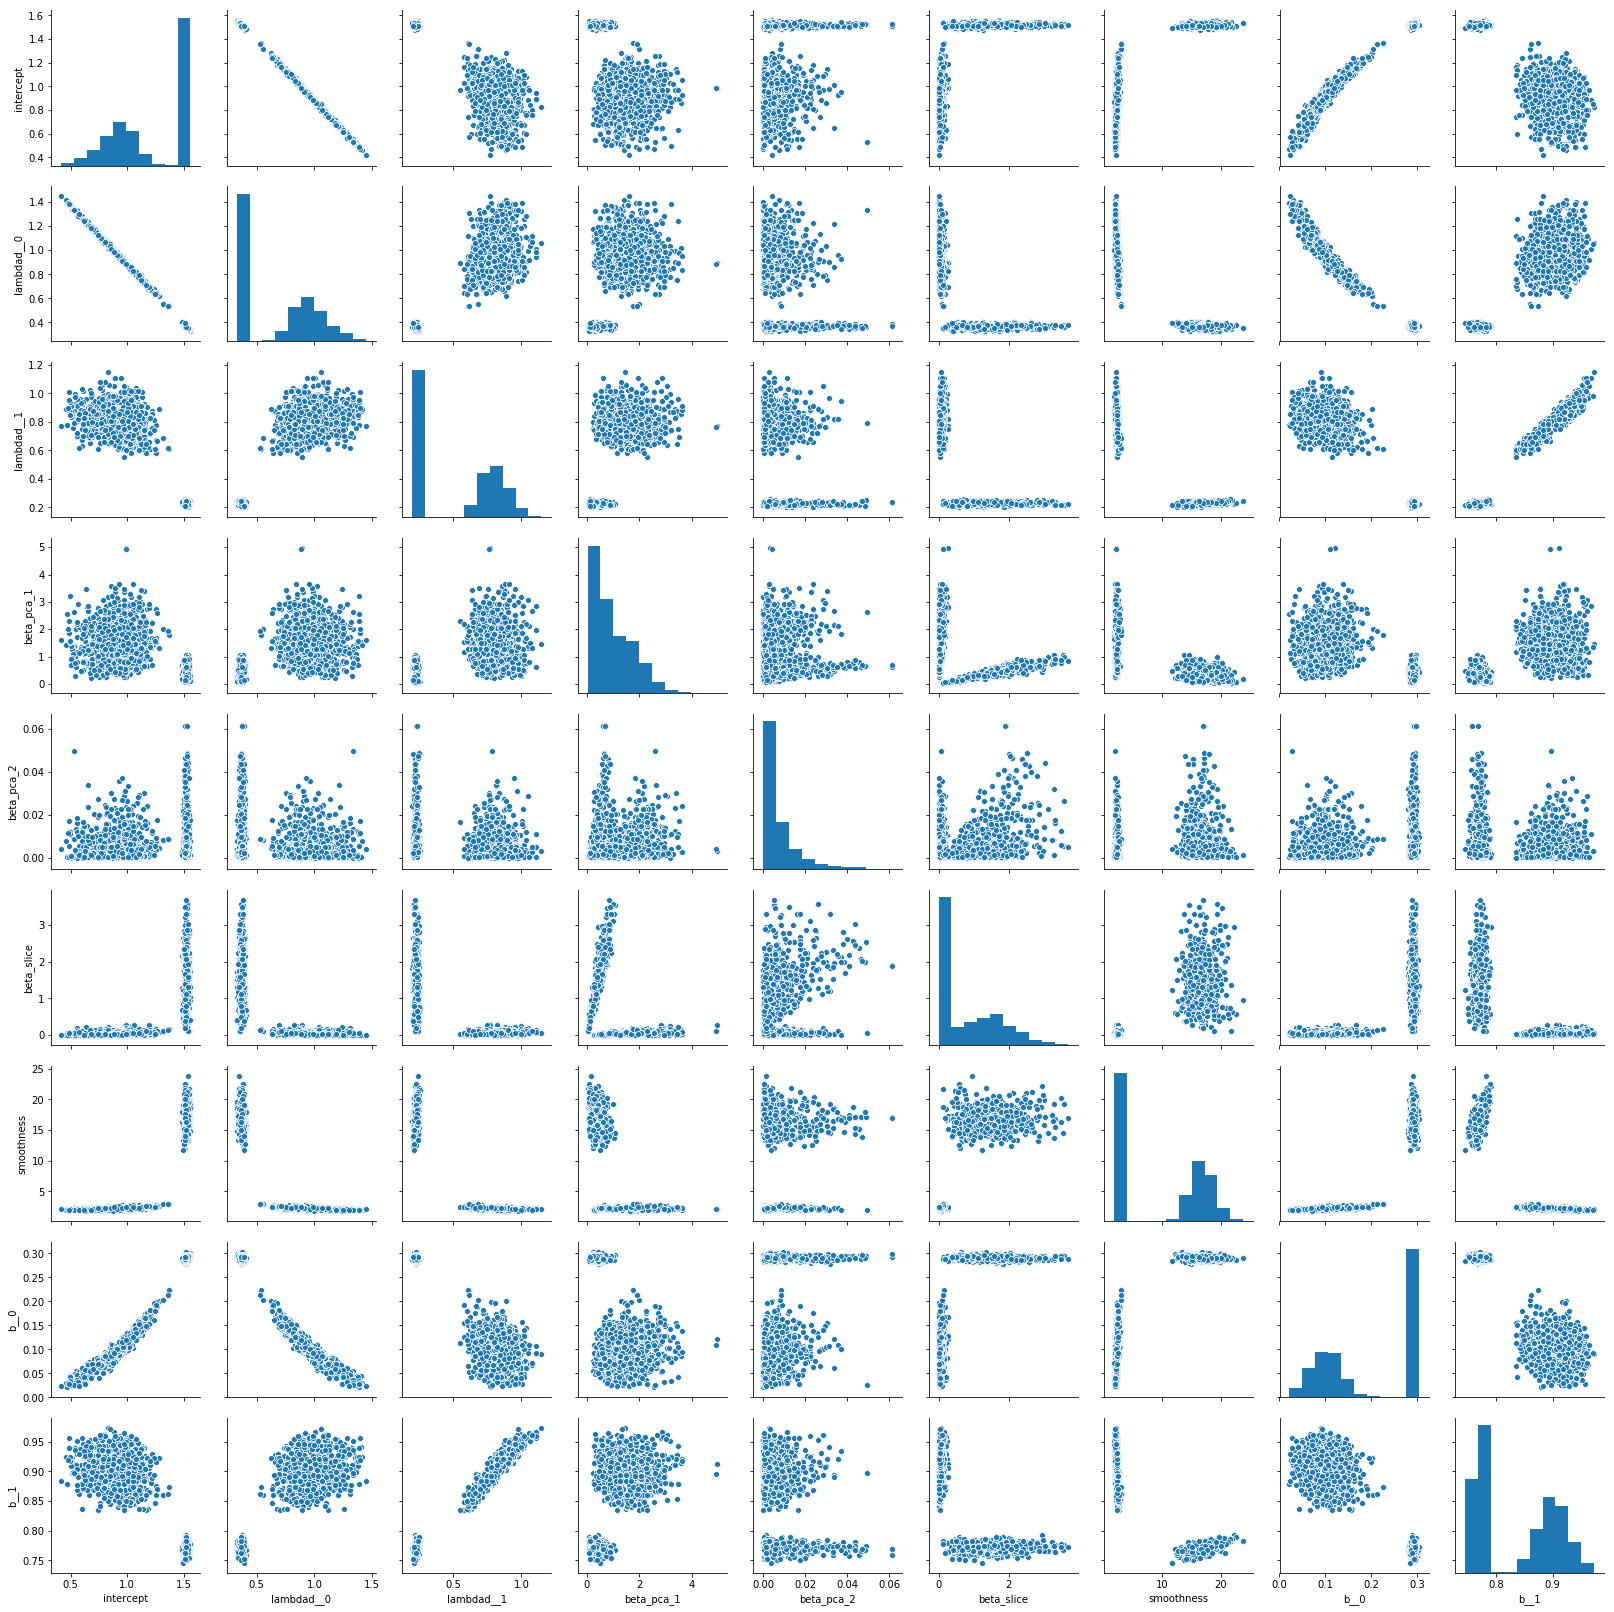

In [646]:
import seaborn as sns
tracedf = pm.trace_to_dataframe(traces)
sns.pairplot(tracedf);

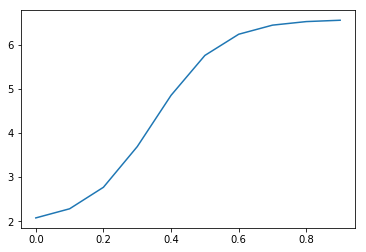

In [563]:

# xs = np.arange(0,1,.1)
# plt.plot(xs, np.exp(0.6671169678266077 + 0.8*np_logistic(1.5187030619787432, 0.322, k=10, t_=xs)))# + 0.5536899070628608*np_logistic(1.5187030619787432, 0.322, k=10, t_=xs)))


No much wrong here - seems to fit well & sample well

## Example that doesn't sample so well

In [576]:
subj_id = 13095 #13095#14037
stain = 'SERT'
model_n = 6
distribution = 'poisson'
model, traces = load_model_traces(subj_id, stain, model_n, distribution)
data_df_idx = (df.subject_id==subj_id) & (df.stain==stain)

ppc = ppc_stn(df=df.loc[data_df_idx,:], trace=traces, model_n=model_n, n_samples=500)
df_tmp = df.loc[data_df_idx,:].copy()
df_tmp['y_predicted'] = ppc.mean(axis=1)

..................................................

mean        sd  mc_error       hpd_2.5   hpd_97.5      n_eff  \
intercept    0.818301  0.110213  0.009977  6.933181e-01   1.096400   8.824744   
lambdad__0   1.011102  0.851831  0.077626 -1.140073e+00   2.134774   8.676183   
lambdad__1  -1.245197  0.830912  0.075495 -2.299725e+00   0.913707   8.727331   
beta_pca_1   1.404139  1.528892  0.125867  1.002595e-01   5.125078  10.865281   
beta_pca_2   0.086536  0.194679  0.011811  3.358653e-07   0.389271  23.158889   
beta_slice   4.188703  2.286551  0.138147  2.158650e-03   8.046211  21.133666   
smoothness  11.832003  1.384244  0.080447  9.386336e+00  14.738558  23.223544   
b__0         0.420419  0.116760  0.011058  3.126515e-01   0.740863   8.068931   
b__1         0.598771  0.091500  0.008628  5.211449e-01   0.844214   8.121752   

                Rhat  
intercept   2.647377  
lambdad__0  2.794600  
lambdad__1  2.742740  
beta_pca_1  1.866247  
beta_pca_2  1.272955  
beta_slice  1.269120  
smoothness  1.239290  
b__0        3.878055  
b__1        3.754829

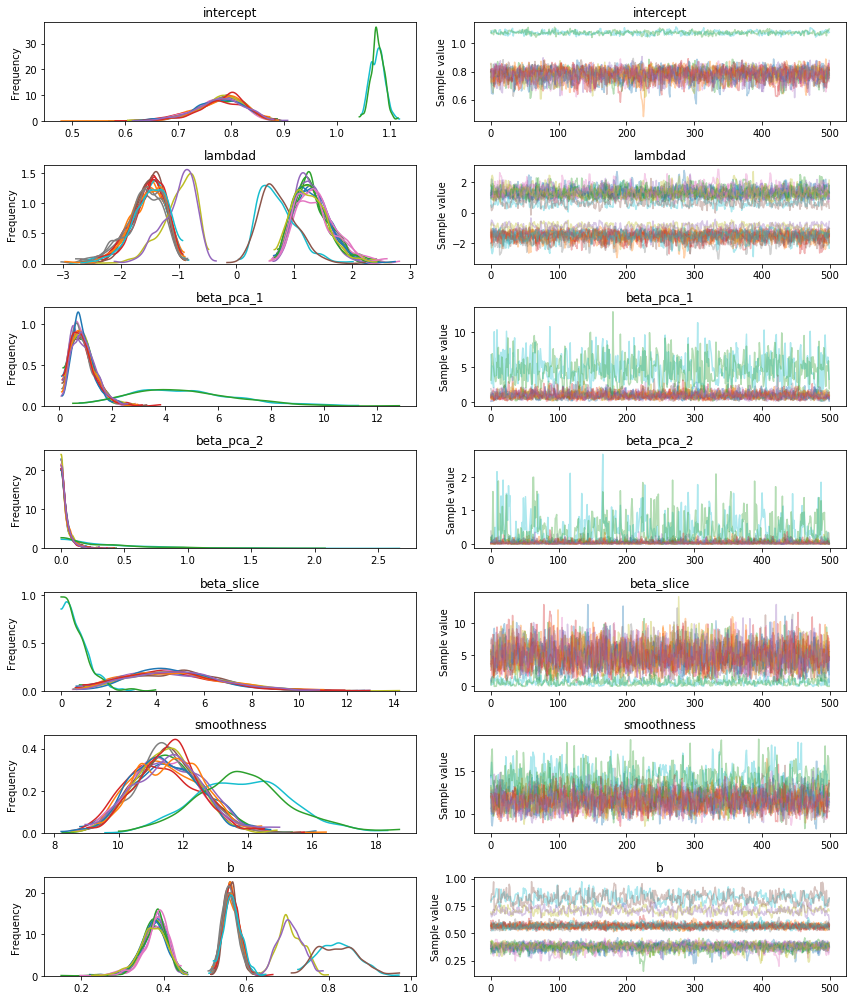

In [577]:
pm.traceplot(traces)
display(pm.summary(traces))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:64: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


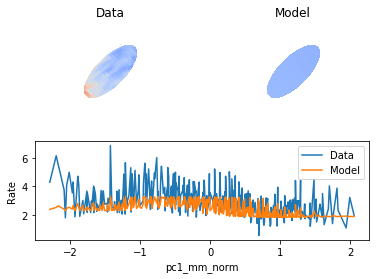

In [578]:
plot_pc1(df_tmp)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:64: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/opt/conda/lib/python3.6/site-package

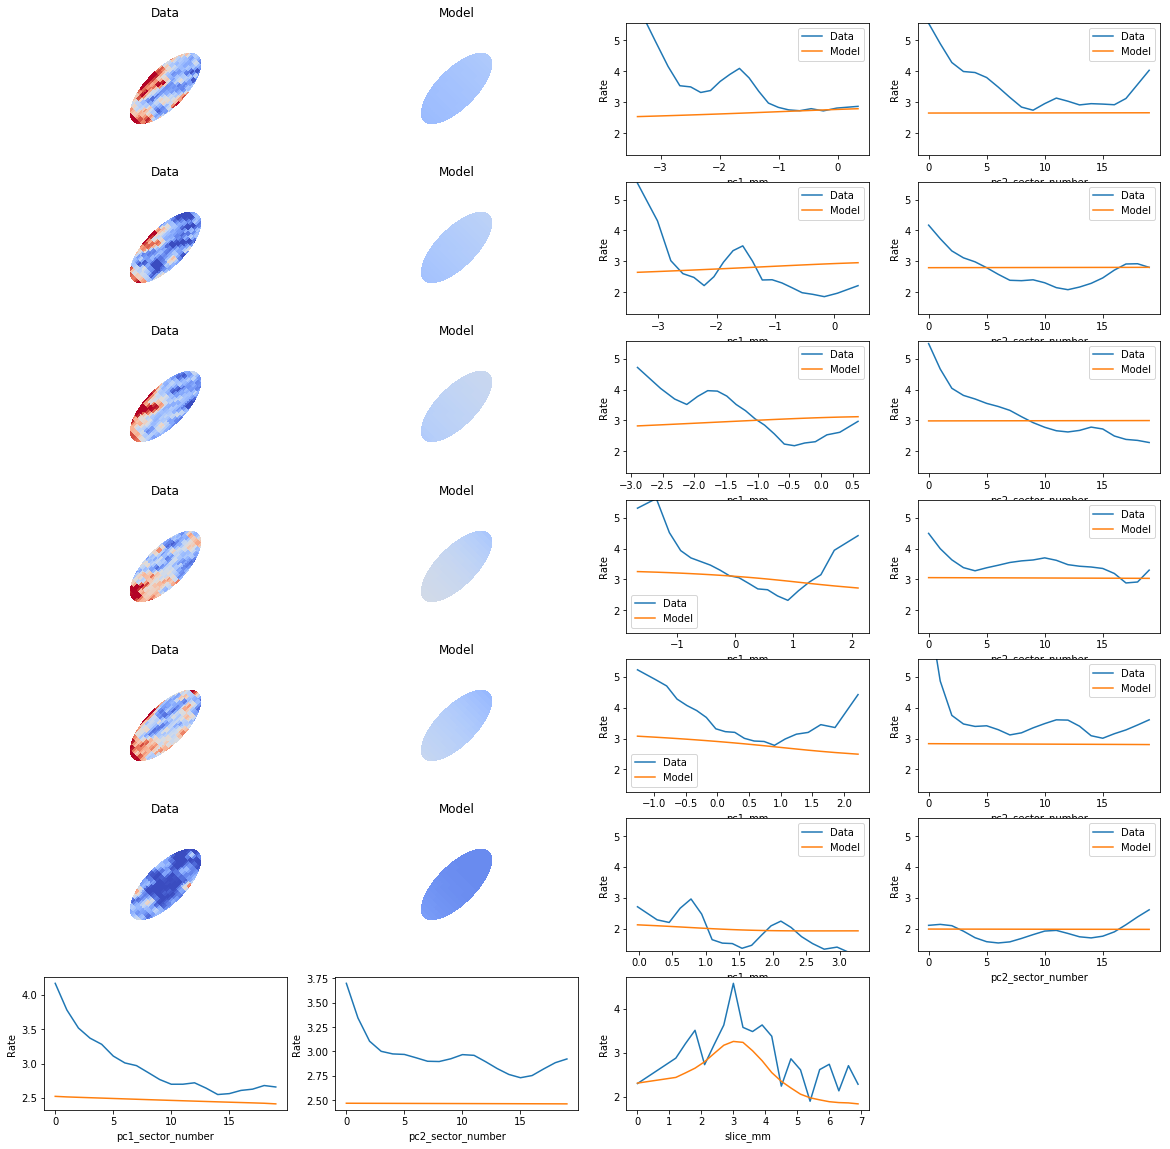

In [579]:
plot_per_slice(df_tmp)

0.8403974237746697
0.8474537410533097
0.381258277439562
0.590074347945392
12.513923111487061


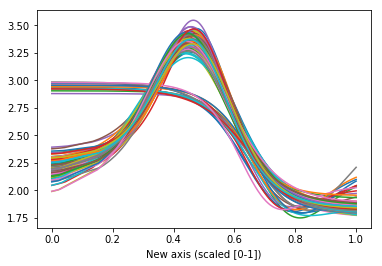

In [582]:
plot_cutoff_axis(traces, df_tmp, n_samples=100, model=model_n)

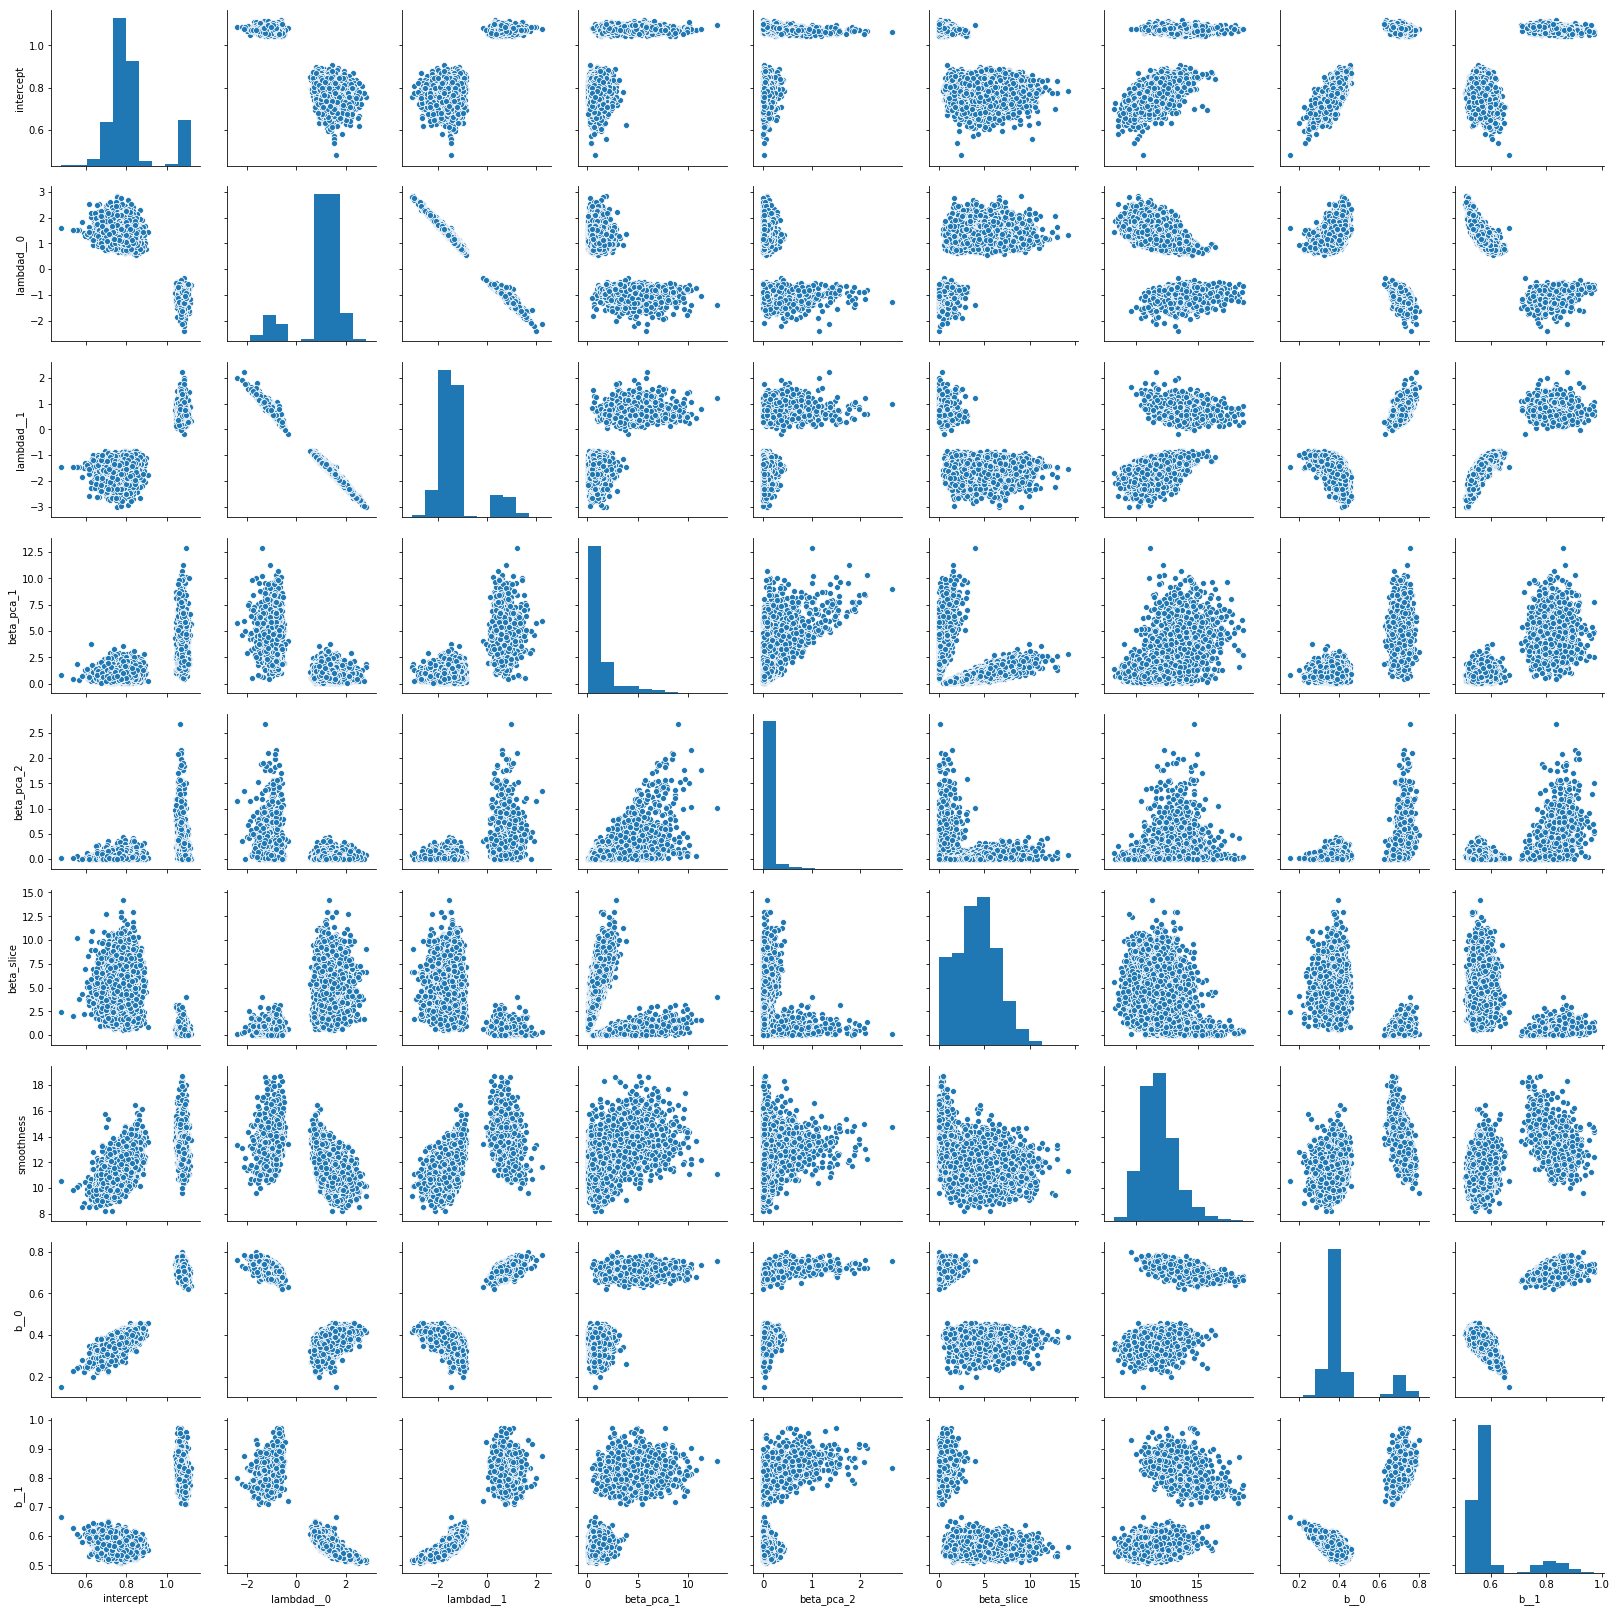

In [581]:
import seaborn as sns
tracedf = pm.trace_to_dataframe(traces)
sns.pairplot(tracedf);

Oops, here the traces seem stuck in local minima with a steep curvature between them (such that they cannot mix). Maybe increase smoothness of transition?

#### Model 8 is the same model as 7, but with the smoothness parameter estimated

In [178]:
subj_id = 13095 #13095#14037
stain = 'SMI32'
model_n = 8
distribution = 'poisson'
model, traces = load_model_traces(subj_id, stain, model_n, distribution)
data_df_idx = (df.subject_id==subj_id) & (df.stain==stain)

ppc = ppc_stn(df=df.loc[data_df_idx,:], trace=traces, model_n=model_n, n_samples=500)
df_tmp = df.loc[data_df_idx,:].copy()
df_tmp['y_predicted'] = ppc.mean(axis=1)

..................................................

mean         sd  mc_error   hpd_2.5   hpd_97.5      n_eff  \
intercept    1.732936   0.275775  0.027412  1.030153   1.826312   8.598228   
smoothness  27.718624  11.145527  1.083084 -0.855764  34.606670   7.632930   
beta_pca_1   2.577673   1.379013  0.099008  0.953199   6.007748  15.087444   
beta_pca_2   3.896719   1.777794  0.092986  1.034144   7.003521  34.474861   
beta_slice   1.678164   1.150191  0.098840  0.533604   5.384801        NaN   
b__0         0.364141   0.201732  0.009010  0.086468   0.819654  68.804486   
b__1         0.889246   0.214410  0.021019  0.335896   0.983484   7.512656   
lambdad__0   0.446737   1.521203  0.148925  0.000026   6.077889   7.636644   
lambdad__1   1.081588   1.176273  0.115235  0.590385   5.331035   7.533131   

                 Rhat  
intercept    3.575134  
smoothness   7.950870  
beta_pca_1   1.452468  
beta_pca_2   1.163776  
beta_slice   2.079335  
b__0         1.086515  
b__1        39.046824  
lambdad__0   9.338458  
lambdad__1  17.499648

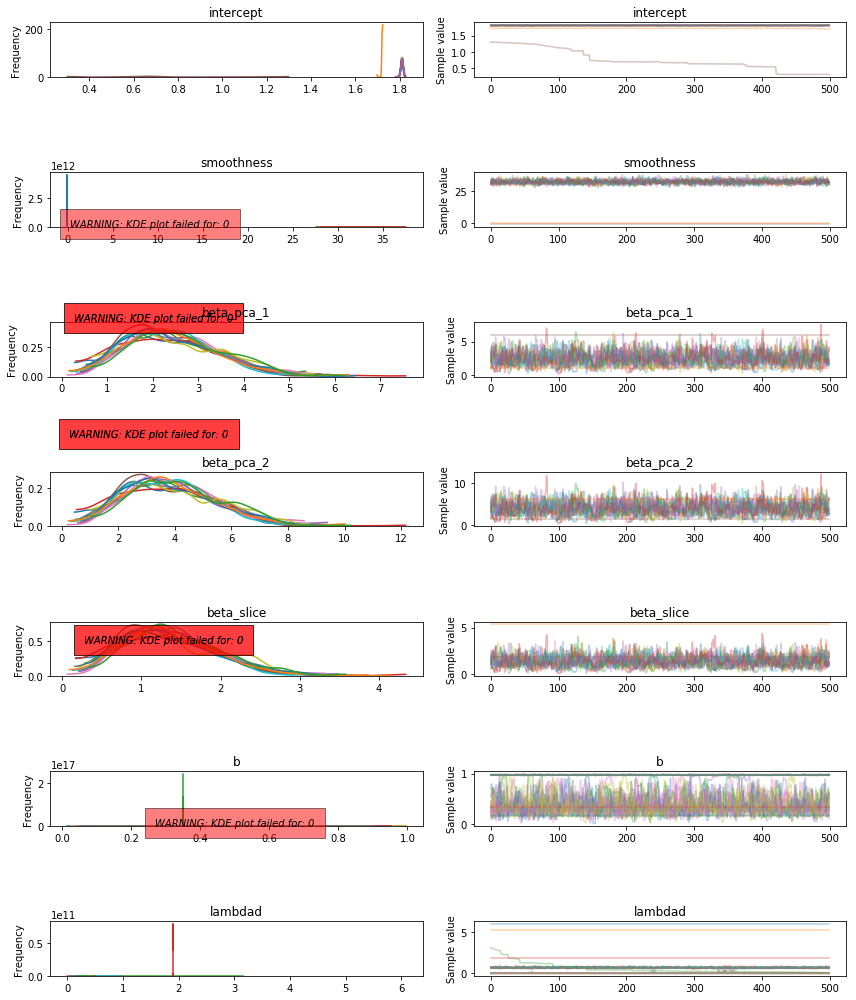

In [179]:
pm.traceplot(traces)
display(pm.summary(traces))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:64: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


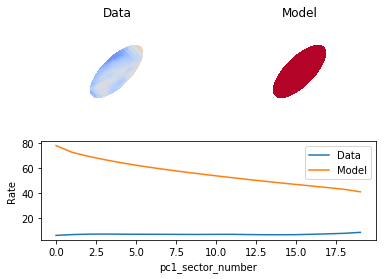

In [180]:
plot_pc1(df_tmp)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:64: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


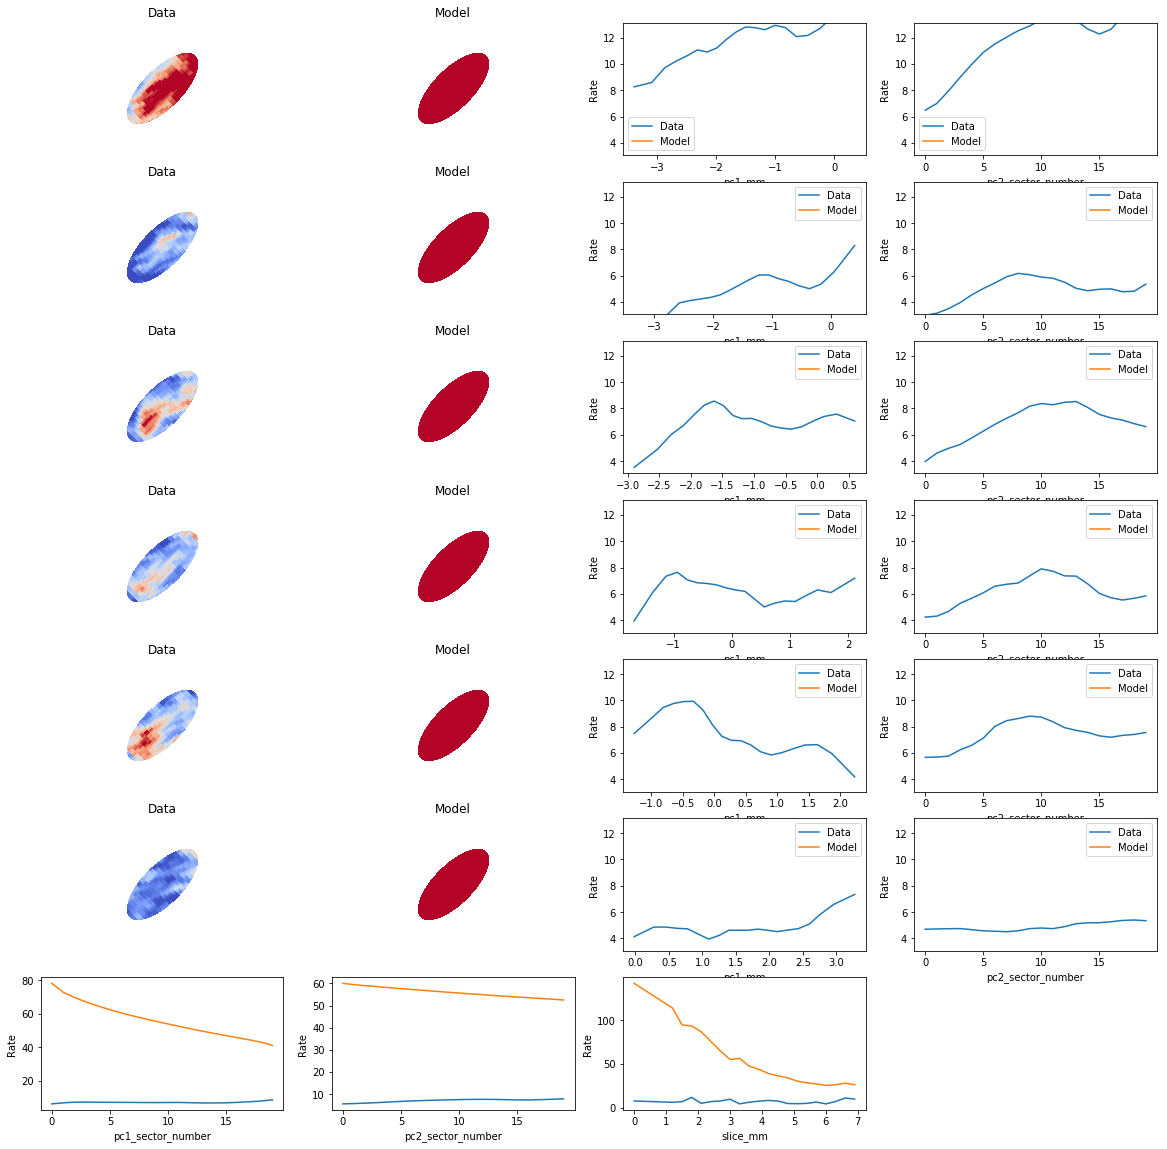

In [181]:
plot_per_slice(df_tmp)

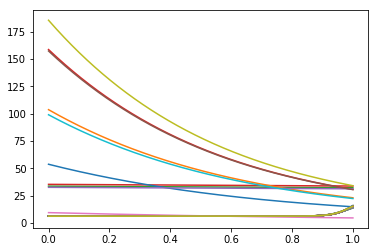

In [182]:
plot_cutoff_axis(traces, model=8)

So this model was able to change the smoothness of the cut-offs, but instead of making them smoother (which visually seems like a good idea), this got they smooth mostly...

How can we improve sampling? This issue seems (to me) to be that the smoothness of the cut-off needs to be a free variable (or adjusted to each specimen/stain separately), but estmating the smoothness works poorly.

Perhaps better priors? What kind of prior should be put on the smoothness? Something >0 at least...

Maybe informed priors on the intercept as well? (e.g., mean of the rates overall)